In [0]:
from datetime import datetime
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('nbagg')
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import warnings 
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
cd gdrive/My\ Drive/Netflix\ Movie\ Recommendation/data_folder

/content/gdrive/My Drive/Netflix Movie Recommendation/data_folder


In [0]:
train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')

In [0]:
def get_sample_data(matrix, num_users, num_movies):
  row_ind, col_ind, ratings = sparse.find(matrix)
  users = np.unique(row_ind)
  movies = np.unique(col_ind)

  print("Unique Users : Unique Movies :: {} : {} ".format(len(users), len(movies)))

  np.random.seed(42)
  sample_users = np.random.choice(users, num_users, replace = False)
  sample_movies = np.random.choice(movies, num_movies, replace = False)

  mask = np.logical_and(np.isin(row_ind, sample_users), np.isin(col_ind, sample_movies))

  sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

  return sample_sparse_matrix

In [0]:
sample_train_sparse_matrix = get_sample_data(train_sparse_matrix, num_users=25000, num_movies=3000)
sample_test_sparse_matrix = get_sample_data(test_sparse_matrix,  num_users=10000, num_movies=1000)

path = "../../AppliedAI/Netflix/sample_train_sparse_matrix.npz"
sparse.save_npz(path, sample_train_sparse_matrix)
path = "../../AppliedAI/Netflix/sample_test_sparse_matrix.npz"
sparse.save_npz(path, sample_test_sparse_matrix)

Unique Users : Unique Movies :: 405041 : 17424 
Unique Users : Unique Movies :: 349312 : 17757 


In [0]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

In [0]:
path = "../../AppliedAI/Netflix/sample_train_sparse_matrix.npz"
sample_train_sparse_matrix = sparse.load_npz(path)
path = "../../AppliedAI/Netflix/sample_test_sparse_matrix.npz"
sample_test_sparse_matrix = sparse.load_npz(path)
print("Train shape : Test Shape :: {} : {} ". format(sample_train_sparse_matrix.shape, sample_test_sparse_matrix.shape))



row_ind, col_ind, ratings  = sparse.find(sample_train_sparse_matrix)
users = np.unique(row_ind)
movies = np.unique(col_ind)
print('\n')
print ("*"*50 + "For Train" + "*"*50)
print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

print ("*"*50 + "For Test " + "*"*50)
row_ind, col_ind, ratings  = sparse.find(sample_test_sparse_matrix)
users = np.unique(row_ind)
movies = np.unique(col_ind)
print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

Train shape : Test Shape :: (2649410, 17766) : (2648886, 17758) 


**************************************************For Train**************************************************
Original Matrix : (users, movies) -- (24064 2985)
Original Matrix : Ratings -- 894294

**************************************************For Test **************************************************
Original Matrix : (users, movies) -- (6835 767)
Original Matrix : Ratings -- 35548



In [0]:
sample_train_averages = dict()

# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\n Average rating of user 290637 :',sample_train_averages['user'][290637])

sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 16495 :',sample_train_averages['movie'][16495])

print('\n No of ratings in Our Sampled train matrix is : {}'.format(sample_train_sparse_matrix.count_nonzero()))
print('\n No of ratings in Our Sampled test  matrix is : {}'.format(sample_test_sparse_matrix.count_nonzero()))


 Average rating of user 290637 : 3.5625

 AVerage rating of movie 16495 : 3.8636363636363638

 No of ratings in Our Sampled train matrix is : 894294

 No of ratings in Our Sampled test  matrix is : 35548


In [0]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [0]:
############################################################
# It took me almost 10 hours to prepare this train dataset #
############################################################
start = datetime.now()
if os.path.isfile('reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        

In [0]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [0]:
start = datetime.now()

if os.path.isfile('reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise

            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        

In [0]:
reg_train = pd.read_csv('reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5


In [0]:
reg_test_df = pd.read_csv('reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5','UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4


## Surprise Library

In [0]:
from surprise import Reader, Dataset

In [0]:
reader = Reader(rating_scale=(1,5))
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)
trainset = train_data.build_full_trainset() 

testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

# Applying Machine Learning Models

In [0]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

In [0]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

###################################################################
###################################################################
def run_xgboost(clf,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()

    
    params = {
      'gamma': [0.25, 0.75],
    
      'max_depth': [4, 8, 9],
      'n_estimators' : [100, 150, 175, 200]
    }
    algo = GridSearchCV(clf, param_grid=params, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results
    



In [0]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()


    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

## 1. XGBosst with Initial 13 Features

In [0]:
import xgboost as xgb
from surprise import BaselineOnly 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy import stats

Training the model..
Done. Time taken : 0:00:34.874479

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0738243242750278
MAPE :  34.82387220649818


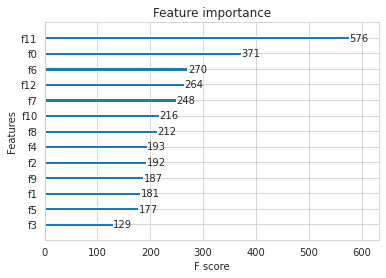

In [0]:
%matplotlib inline

# Prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

from sklearn.preprocessing import normalize
x_train = normalize(x_train)
x_test = normalize(x_test)


# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html
prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
# initialize Our first XGBoost model...
base_xgb_reg = xgb.XGBRegressor(silent=True, n_jobs=-1, random_state=0)

# Obtaining the best hyperparameters using Randomized Search CV
start =datetime.now() 
best_xgb = RandomizedSearchCV(base_xgb_reg, param_distributions= params, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
best_xgb.fit(x_train, y_train)
 

#Update the XGBoost regressor with best params obtained from hyperparameter tuning
first_xgb = base_xgb_reg.set_params(**best_xgb.best_params_) 

# Build a XGBRegressor model with the best value of Hyperparameter obtained from above
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# Store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

#Plot feature importances
xgb.plot_importance(first_xgb)
plt.show()

### Base LIne Model

In [0]:
# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:00.781205 

Evaluating the model with train data..
time taken : 0:00:01.061172
---------------
Train Data
---------------
RMSE : 0.9347153928678286

MAPE : 29.389572652358183

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.056939
---------------
Test Data
---------------
RMSE : 1.0730330260516174

MAPE : 35.04995544572911

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:01.900500


### XGBoost with intital 13 features + Surprise Baseline predictor

In [0]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2) 


,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403


In [0]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679


### Xgboost with 13 features + baseline variable

Training the model..
Done. Time taken : 0:00:07.649909

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.073449428186246
MAPE :  34.90177562390789


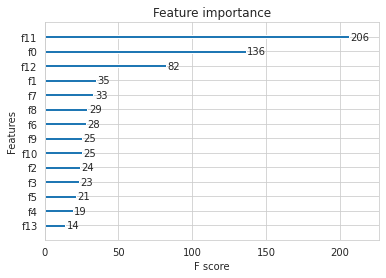

In [0]:
%matplotlib inline

# Prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']
from sklearn.preprocessing import normalize
x_train = normalize(x_train)
x_test = normalize(x_test)


# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html
prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}



# initialize Our first XGBoost model...
base_xgb_reg = xgb.XGBRegressor(silent=True, n_jobs=-1, random_state=0)

# Obtaining the best hyperparameters using Randomized Search CV
start =datetime.now() 
best_xgb = RandomizedSearchCV(base_xgb_reg, param_distributions= params, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
best_xgb.fit(x_train, y_train)
 

#Update the XGBoost regressor with best params obtained from hyperparameter tuning
first_xgb = base_xgb_reg.set_params(**best_xgb.best_params_) 

# Build a XGBRegressor model with the best value of Hyperparameter obtained from above
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

#Plot feature importances
xgb.plot_importance(first_xgb)
plt.show()

### Surprise KNNBaseline with user user similarity

In [0]:
from surprise import KNNBaseline
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:28.373290 

Evaluating the model with train data..
time taken : 0:01:39.344155
---------------
Train Data
---------------
RMSE : 0.33642097416508826

MAPE : 9.145093375416348

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.066112
---------------
Test Data
---------------
RMSE : 1.0726493739667242

MAPE : 35.02094499698424

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:02:07.784879


### KNNBaseLine with movie movie similarity

In [0]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of movies instead of users

sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:00.899254 

Evaluating the model with train data..
time taken : 0:00:09.018361
---------------
Train Data
---------------
RMSE : 0.32584796251610554

MAPE : 8.447062581998374

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.189937
---------------
Test Data
---------------
RMSE : 1.072758832653683

MAPE : 35.02269653015042

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:10.109124


In [0]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']


reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

### XGBoost with 13 features + baseline + KNNbaseline featurese

Training the model..
Done. Time taken : 0:00:08.289299

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0740411404904187
MAPE :  35.35767213805891


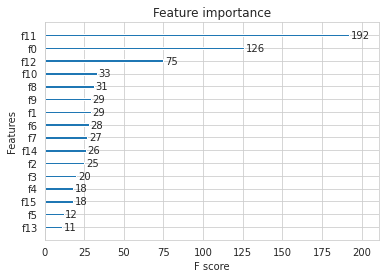

In [0]:
%matplotlib inline

# Prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']
from sklearn.preprocessing import normalize
x_train = normalize(x_train)
x_test = normalize(x_test)


# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html
prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}

# initialize Our first XGBoost model...
base_xgb_reg = xgb.XGBRegressor(silent=True, n_jobs=-1, random_state=0)

# Obtaining the best hyperparameters using Randomized Search CV
start =datetime.now()
print('Hyperparameter tuning: \n')
best_xgb = RandomizedSearchCV(base_xgb_reg, param_distributions= params, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
best_xgb.fit(x_train, y_train)
print('Time taken to perform Hyperparameter tuning :',datetime.now()-start)


#Update the XGBoost regressor with best params obtained from hyperparameter tuning
first_xgb = base_xgb_reg.set_params(**best_xgb.best_params_) 

# Build a XGBRegressor model with the best value of Hyperparameter obtained from above
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# Store the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results

#Plot feature importances
xgb.plot_importance(first_xgb)
plt.show()

###  SVD Matrix Factorization User Movie intractions

In [0]:
from surprise import SVD
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:07.536631 

Evaluating the model with train data..
time taken : 0:00:01.134338
---------------
Train Data
---------------
RMSE : 0.6574721240954099

MAPE : 19.704901088660474

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.062920
---------------
Test Data
---------------
RMSE : 1.0726046873826458

MAPE : 35.01953535988152

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:08.735093


In [0]:

svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd.fit(trainset)
svd.test(trainset.build_testset())

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


[Prediction(uid=53406, iid=33, r_ui=4.0, est=4.3037638270810366, details={'was_impossible': False}),
 Prediction(uid=53406, iid=107, r_ui=3.0, est=3.2789671084155616, details={'was_impossible': False}),
 Prediction(uid=53406, iid=483, r_ui=4.0, est=3.385722688609307, details={'was_impossible': False}),
 Prediction(uid=53406, iid=607, r_ui=3.0, est=2.944655539278606, details={'was_impossible': False}),
 Prediction(uid=53406, iid=937, r_ui=3.0, est=3.4561194495850347, details={'was_impossible': False}),
 Prediction(uid=53406, iid=1585, r_ui=2.0, est=2.55904747795082, details={'was_impossible': False}),
 Prediction(uid=53406, iid=2874, r_ui=3.0, est=2.719642728052601, details={'was_impossible': False}),
 Prediction(uid=53406, iid=3077, r_ui=3.0, est=2.62962242168419, details={'was_impossible': False}),
 Prediction(uid=53406, iid=4109, r_ui=2.0, est=3.14129653041985, details={'was_impossible': False}),
 Prediction(uid=53406, iid=4356, r_ui=4.0, est=4.115812210055531, details={'was_impossib

### SVD Matrix Factorization with implicit feedback from user 

In [0]:
from surprise import SVDpp
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results


Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:02:04.045226 

Evaluating the model with train data..
time taken : 0:00:06.240901
---------------
Train Data
---------------
RMSE : 0.6032438403305899

MAPE : 17.49285063490268

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.184878
---------------
Test Data
---------------
RMSE : 1.0728491944183447

MAPE : 35.03817913919887

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:02:10.472266


In [0]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

###  XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques

Hyperparameter tuning: 

Time taken to perform Hyperparameter tuning : 0:42:41.316175
Training the model..
Done. Time taken : 0:00:25.105007

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0734006702053527
MAPE :  35.090761435314214


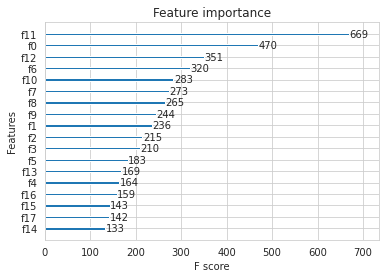

In [0]:
%matplotlib inline

# Prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

from sklearn.preprocessing import normalize
x_train = normalize(x_train)
x_test = normalize(x_test)


# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html
params = { 
          'n_estimators':sp_randint(100,500),
          'gamma':stats.uniform(0,0.02),
          'max_depth':np.arange(1,11),
}

# initialize Our first XGBoost model...
base_xgb_reg = xgb.XGBRegressor(silent=True, n_jobs=-1, random_state=0)

# Obtaining the best hyperparameters using Randomized Search CV
start =datetime.now()
print('Hyperparameter tuning: \n')
best_xgb = RandomizedSearchCV(base_xgb_reg, param_distributions= params, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
best_xgb.fit(x_train, y_train)
print('Time taken to perform Hyperparameter tuning :',datetime.now()-start)


#Update the XGBoost regressor with best params obtained from hyperparameter tuning
first_xgb = base_xgb_reg.set_params(**best_xgb.best_params_) 

# Build a XGBRegressor model with the best value of Hyperparameter obtained from above
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# Store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results

#Plot feature importances
xgb.plot_importance(first_xgb)
plt.show()

### XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques

Hyperparameter tuning: 

Time taken to perform Hyperparameter tuning : 0:04:51.616503
Training the model..
Done. Time taken : 0:00:05.021592

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0751240065004763
MAPE :  35.22636704122139


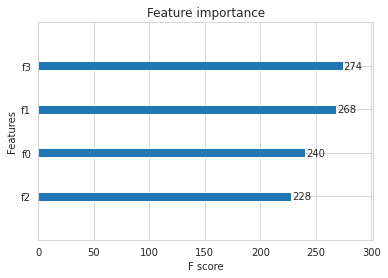

In [0]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']


from sklearn.preprocessing import normalize
x_train = normalize(x_train)
x_test = normalize(x_test)


# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html
prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
# initialize Our first XGBoost model...
base_xgb_reg = xgb.XGBRegressor(silent=True, n_jobs=-1, random_state=0)

# Obtaining the best hyperparameters using Randomized Search CV
start =datetime.now()
print('Hyperparameter tuning: \n')
best_xgb = RandomizedSearchCV(base_xgb_reg, param_distributions= params, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
best_xgb.fit(x_train, y_train)
print('Time taken to perform Hyperparameter tuning :',datetime.now()-start)


#Update the XGBoost regressor with best params obtained from hyperparameter tuning
first_xgb = base_xgb_reg.set_params(**best_xgb.best_params_) 

# Build a XGBRegressor model with the best value of Hyperparameter obtained from above
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# Store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

#Plot feature importances
xgb.plot_importance(first_xgb)
plt.show()

### Comparision between models

In [0]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_test).to_csv('../../AppliedAI/Netflix/small_sample_results.csv')
models = pd.read_csv('../../AppliedAI/Netflix/small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

svd               1.0726046873826458
knn_bsl_u         1.0726493739667242
knn_bsl_m          1.072758832653683
svdpp             1.0728491944183447
bsl_algo          1.0730330260516174
xgb_final         1.0734006702053527
xgb_bsl            1.073449428186246
first_algo         1.073487800478122
xgb_knn_bsl       1.0740411404904187
xgb_all_models    1.0751240065004763
Name: rmse, dtype: object